<a href="https://colab.research.google.com/github/KrishnanandaRajkumar/cluster-in-ml/blob/main/KMeans_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F168951%2F383783%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T051427Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D558e062826460ae1532dbe11c6e3ce26f7b4175585af0bae2b467c8092e6e9157fd774704ffaf8cca76141d590345aafa1fa20705277c156f39ce4709580f19e4ac6ccbaca7049276a8f04e183aa1056715f9cc5bff88182a90b4cc7a45b15d45651837e9d667cbf6c785c9a89fe8cc36ccf9b1f9635aaa84f884e0e0167be114ec42248f58bf23b1b76bfc137c48ffdac96665c81d8c12c36b4470e70450a94453aa7678ed699891a6bb05363796856760929f8c6c66b4e45dd7a1fa864cbe01cbe0179f9648fabb1568694cfe108b765e9e260e45bbc83c7137885a412cb2b395bed20422f39873e672907247e0958b6b491c09ee750543f63536a73987d3b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1578 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


### *Table of content*

[1. What does KMeans do?](#1)


[2. Applications](#2)


[3. Working](#3)


[4. Choosing the right K](#4)



[5. Centroid Random Initialisation Trap](#5)



[6. Implemention](#6)



[7. Visualisation](#7)

<a id="1"></a>
## 1. What does KMeans do?

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. The results of the K-means clustering algorithm are:

* The centroids of the K clusters, which can be used to label new data
* Labels for the training data (each data point is assigned to a single cluster)

![](https://imgur.com/a/wVDJPuZ)

![](https://i.imgur.com/rwkQNbv.png)

<a id="2"></a>
## 2. Applications
The K-means clustering algorithm is used to find groups which have not been explicitly labeled in the data. This can be used to confirm business assumptions about what types of groups exist or to identify unknown groups in complex data sets. Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the correct group.

This is a versatile algorithm that can be used for any type of grouping. Some examples of use cases are:

* Behavioral segmentation:
* * Segment by purchase history
* * Segment by activities on application, website, or platform
* * Define personas based on interests
* * Create profiles based on activity monitoring
* Inventory categorization:
* * Group inventory by sales activity
* * Group inventory by manufacturing metrics
* Sorting sensor measurements:
* * Detect activity types in motion sensors
* * Group images
* * Separate audio
* * Identify groups in health monitoring
* Detecting bots or anomalies:
* * Separate valid activity groups from bots

<a id="3"></a>
## 3. Working

Let's now discuss the working of KMeans algorithm. The aim is to break the explanation down in the simplest way possible.


#### It begins with choosing the number of K clusters. The K signifies the number of clusters that the algorithm would find in the dataset. Now choosing the right K is very important. Sometimes the K is clearly visible from the dataset when visualized. However most of the times this is not the case and in a short time we'll see about how to choose the right K value.



![](https://i.imgur.com/RBK4dtA.png)


#### The second step is to allocate K random points as centroids. These K points could be points from the dataset or outside. There's one thing to note however. The random initialisation of centroids can sometimes cause random initialisation trap which we would see in this section soon.

![](https://i.imgur.com/LfI2qfl.png)

#### In the third step the dataset points would be allocated to the centroid which is closest to them.



![](https://i.imgur.com/9I5JH3m.png)


#### The fourth step is to calculate the centroid of the individual clusters and place the old centroid there.




![](https://i.imgur.com/FyIeKuA.png)

#### The fifth step is to reassign points like we did in step 3. If reassignment takes place then we need to go back to step four. If no reassignment takes place then we can say that our model has converged and its ready.




![](https://i.imgur.com/aRaGcKB.png)

## Step Summary
### To summarise the steps we can say :
![](https://i.imgur.com/3jTk7Y0.png)

<a id="4"></a>
## 4. Choosing the right K

The way to evaluate the choice of K is made using a parameter known as WCSS. WCSS stands for **Within Cluster Sum of Squares**.
It should be low. Here's the formula representation for example when K = 3

Summation Distance(p,c) is the sum of distance of points in a cluster from the centroid.


![](https://i.imgur.com/5W63xul.png)

The Elbow Method is then used to choose the best K value. In the depiction below we can see that after 3 there's no significant decrease in WCSS so 3 is the best here. Therefore there's an elbow shape that forms and it is usually a good idea to pick the number where this elbow is formed. There would be many times when the graph wouldn't be this intuitive but with practice it becomes easier.

![](https://i.imgur.com/gi9p7V5.png)

<a id="5"></a>
## 5. Centroid Random Initialisation Trap

Through these images let's see how two different random initialisations can cause a totally different outcome.

### Init 1



![](https://i.imgur.com/zsC9z0z.png)




### Init 2



![](https://i.imgur.com/kU5BX6j.png)

So we saw that even with clear distinction possible visually, wrong randomisation can produce wrong results.
There have been researches carried out and one of the most famous ways to initialise centroids is KMeans++.
The best thing is that the whole algorithm remains the same but the only difference is that we provide an argument to SKlearn to use KMeans++ for initialisation. There are many papers explaining the KMeans++ but the explanation is beyond this notebook for now. :)

![](https://cdn-images-1.medium.com/max/1200/1*x7P7gqjo8k2_bj2rTQWAfg.jpeg)

<a id="6"></a>
## 6. Implementation

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
print(os.listdir("../input"))

['Mall_Customers.csv']


In [ ]:
# Importing the dataset
dataset = pd.read_csv('../input/Mall_Customers.csv',index_col='CustomerID')

In [ ]:
dataset.head()

,Genre,Age,Annual_Income_(k$),Spending_Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Genre               200 non-null    object
 1   Age                 200 non-null    int64 
 2   Annual_Income_(k$)  200 non-null    int64 
 3   Spending_Score      200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [ ]:
dataset.describe()

,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [ ]:
dataset.isnull().sum()

,0
Genre,0
Age,0
Annual_Income_(k$),0
Spending_Score,0


No Nans found! Great

In [ ]:
dataset.drop_duplicates(inplace=True)

In [ ]:
# using only Spending_Score and income variable for easy visualisation
X = dataset.iloc[:, [2, 3]].values

In [ ]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

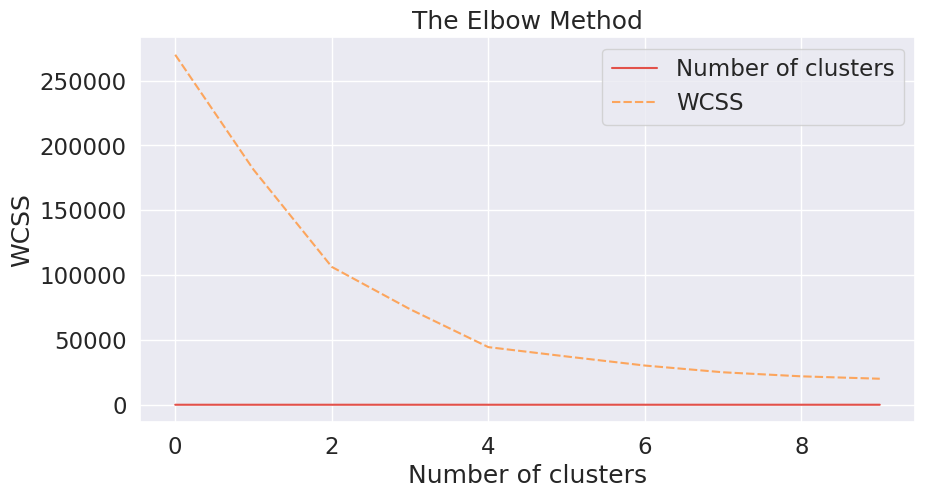

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot({'Number of clusters': range(1, 11), 'WCSS': wcss})
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<a id="7"></a>
## 7. Visualisation

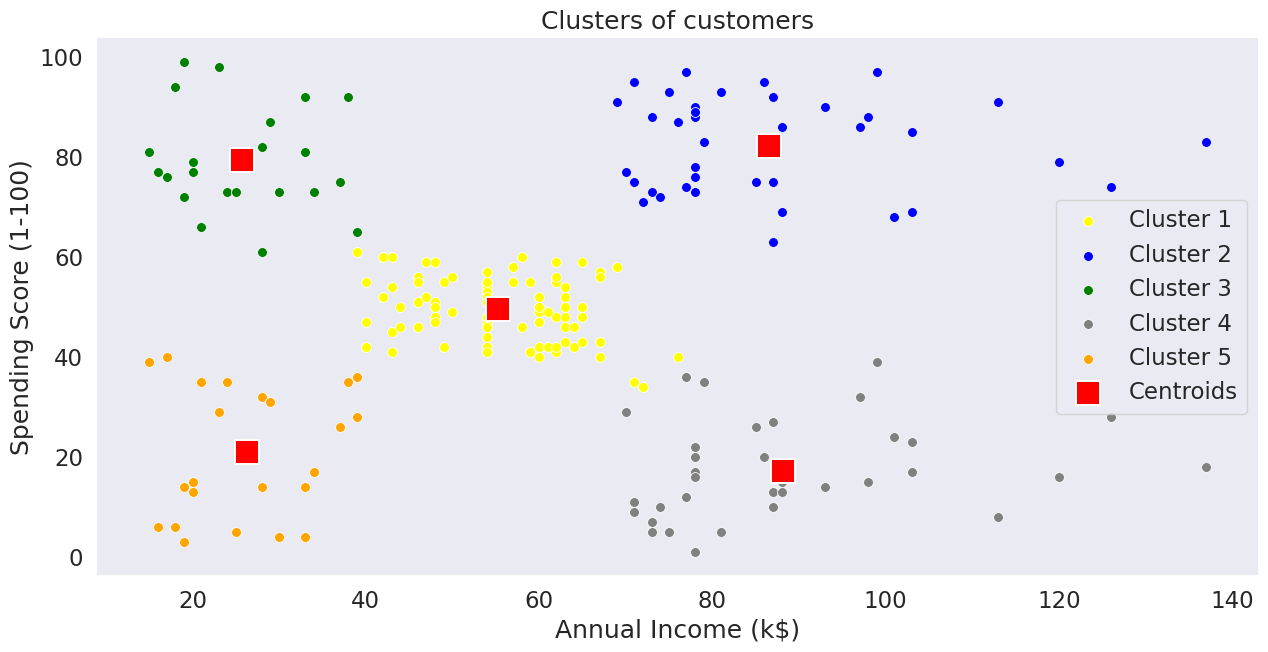

In [ ]:
# Visualising the clusters
plt.figure(figsize=(15,7))
sns.scatterplot(x=X[y_kmeans == 0, 0], y=X[y_kmeans == 0, 1], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(x=X[y_kmeans == 1, 0], y=X[y_kmeans == 1, 1], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(x=X[y_kmeans == 2, 0], y=X[y_kmeans == 2, 1], color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(x=X[y_kmeans == 3, 0], y=X[y_kmeans == 3, 1], color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(x=X[y_kmeans == 4, 0], y=X[y_kmeans == 4, 1], color = 'orange', label = 'Cluster 5',s=50)
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color = 'red',
                label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()